In [30]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 700,700
from tabs import DihedralInfoFromTorsionLib
from tabs import custom
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from helpers import GetTabsPopulationMatrix, CheckForCorrelationCandidates, Shift
import pandas as pd
import warnings

In [31]:
plt.rcParams["font.size"] = 14
# setting the binsize used for all histograms in this notebook
binsize = np.pi*2/36

Reading in the macrocycle example structure

In [32]:
mol = Chem.MolFromMolFile("../Data/Tests/macrocycle.sdf",removeHs=False)

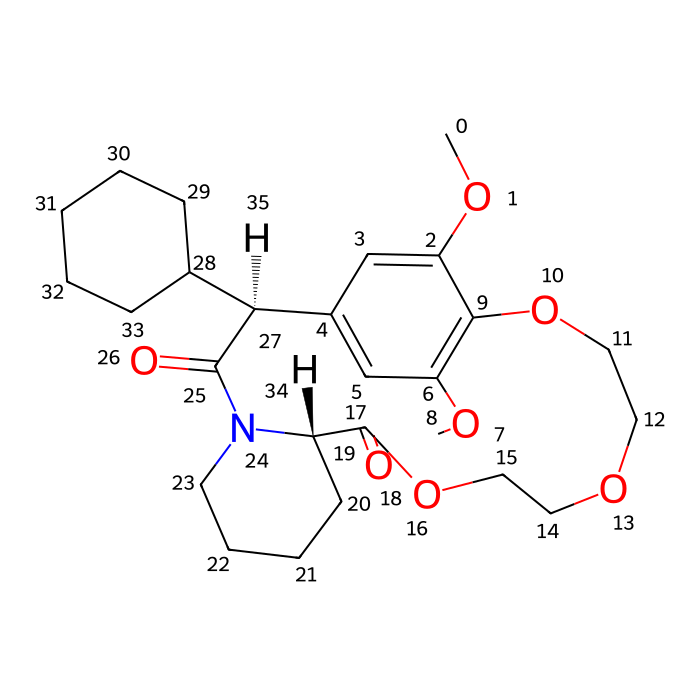

In [33]:
rdDepictor.SetPreferCoordGen(True)
mol.RemoveAllConformers()
Chem.RemoveHs(mol)

Getting the experimental torsion information matched through the ET terms in the ETKDG and also add additional dihedrals of interest (remaining dihedrals of the ring structure). The reason for that is that there are some dihedrals in the ring which are unmatched by any ET term.

In [34]:
etInfo = DihedralInfoFromTorsionLib(mol)
# get indices where TorsionType is MACROCYCLE
macrocycle_indices = [i for i, torsion in enumerate(etInfo.torsionTypes) if torsion == 3]
mcDihedrals = etInfo.indices[15:]
mcDihedrals.append([2,9,10,11])
mcDihedrals.append([3,4,27,25])
mcDihedrals.append([24,19,17,16])
mcDihedrals

[[27, 25, 24, 19],
 [18, 17, 16, 15],
 [17, 16, 15, 14],
 [11, 12, 13, 14],
 [15, 14, 13, 12],
 [12, 11, 10, 9],
 [10, 11, 12, 13],
 [13, 14, 15, 16],
 [4, 27, 25, 26],
 [2, 9, 10, 11],
 [3, 4, 27, 25],
 [24, 19, 17, 16]]

# Correlation Analysis

The original data can be found in Brudy, C.; Ruijsenaars, E.; Meyners, C.; Sugiarto, W.; Achaq, H.; Spiske, M.; Buffa, V.; Springer, M.; Schmidt, M.; Riniker, S.; Hausch, F. Conformational Domino: Linker modification enables control of key functional group orientation in macrocycles. J. Med. Chem. 2025, submitted .

Reading in the already extracted metadata (dihedral profiles). The keys are the atom indices of the dihedrals and associated are the torsion profiles in radians.

In [35]:
import pickle

In [36]:
profiles = pickle.load(open("../Data/Tests/macrocycleDihedralProfiles.pkl", "rb"))

In [37]:
profiles.keys()

dict_keys([(27, 25, 24, 19), (18, 17, 16, 15), (17, 16, 15, 14), (11, 12, 13, 14), (15, 14, 13, 12), (12, 11, 10, 9), (10, 11, 12, 13), (13, 14, 15, 16), (4, 27, 25, 26), (2, 9, 10, 11), (3, 4, 27, 25), (24, 19, 17, 16)])

Check which profiles only exhibit one state as they are then not of interest

In [38]:
idxs = CheckForCorrelationCandidates(mol, mcDihedrals, profiles, threshold=1)

Dihedral [27, 25, 24, 19] not relevant: [6.99965002e-02 9.99300035e+01]
Dihedral [18, 17, 16, 15] not relevant: [99.08504575  0.91495425]
Dihedral [4, 27, 25, 26] not relevant: [9.99350032e+01 6.49967502e-02]
Dihedral [3, 4, 27, 25] not relevant: [100.]


In [39]:
idxs

[[17, 16, 15, 14],
 [11, 12, 13, 14],
 [15, 14, 13, 12],
 [12, 11, 10, 9],
 [10, 11, 12, 13],
 [13, 14, 15, 16],
 [2, 9, 10, 11],
 [24, 19, 17, 16]]

Writing out all possible pairs

In [40]:
# get all pairs of dihedrals
pairs = []
for i in range(len(idxs)):
    for j in range(i+1, len(idxs)):
        pairs.append((idxs[i], idxs[j]))

In order to conduct the customTABS analysis, we need to build a `DihedralsInfo` object (here: info2) with the two selected torsions to base the TABS construction on and pass the two extracted torsion distributions for those cases as custom torsions.

Then, we calculate all the TABS based on the two torsions with `info2.GetTABS` and based on this customTABS population, we construct a population matrix, e.g. if both dihedrals have two states each (the row and column names are the state names for dihedral A and B):

|   | 1  | 2  |
|---|----|----|
| 1 | 23 | 2  |
| 2 | 21 | 56 |

Afterwards, we can analyize this population matrix for correlation using the chi-square test of independence (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

In [41]:
pValues = []
for pairIndex in range(len(pairs)):
    # join the two arrays into one 2D array
    tmp = profiles[tuple(pairs[pairIndex][0])]
    tmp = np.hstack([tmp, profiles[tuple(pairs[pairIndex][1])]])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        # code that emits warnings    
        # create DihedralInfo object for the two dihedrals, pass the two observed distributions as custom torsions
        info2 = custom.CustomDihedralInfo(mol, pairs[pairIndex], tmp, showFits=False)
    tabsPopulationTraj = info2.GetTABS(confTorsions=tmp)
    # count the number for each unique value
    unique, counts = np.unique(tabsPopulationTraj, return_counts=True)
    m = GetTabsPopulationMatrix(unique, counts)
    res = chi2_contingency(m)
    pValues.append((pairs[pairIndex][0], pairs[pairIndex][1], res.statistic, res.pvalue))
res = pd.DataFrame(pValues, columns=["Dihedral A", "Dihedral B", "stats", "p-value"])

In [42]:
res

,Dihedral A,Dihedral B,stats,p-value
0,"[17, 16, 15, 14]","[11, 12, 13, 14]",701.290352,1.831638e-150
1,"[17, 16, 15, 14]","[15, 14, 13, 12]",10657.775378,0.000000e+00
2,"[17, 16, 15, 14]","[12, 11, 10, 9]",671.231540,1.753570e-146
3,"[17, 16, 15, 14]","[10, 11, 12, 13]",431.951793,1.595364e-94
4,"[17, 16, 15, 14]","[13, 14, 15, 16]",4721.325023,0.000000e+00
5,"[17, 16, 15, 14]","[2, 9, 10, 11]",599.516498,6.556115e-131
6,"[17, 16, 15, 14]","[24, 19, 17, 16]",2370.976586,0.000000e+00
7,"[11, 12, 13, 14]","[15, 14, 13, 12]",1040.237211,6.796672e-224
8,"[11, 12, 13, 14]","[12, 11, 10, 9]",8888.799601,0.000000e+00
9,"[11, 12, 13, 14]","[10, 11, 12, 13]",7747.287534,0.000000e+00


As the target dihedral is known, we can filter for the correlations with (24, 19, 17, 16)

In [43]:
res.sort_values(by="p-value", ascending=True, inplace=False)
target = [24, 19, 17, 16]
sub = res[res["Dihedral B"].apply(lambda x: x == target)]

Inspection of the results: All pairs with a p-value < 0.05 are considered correlated.
From all correlated pairs, we see that there are two that show the highest test statistic with the target dihedral: [17,16,15,14] and [13,14,15,16].

In [44]:
sub.sort_values(by="stats", ascending=True, inplace=False)

,Dihedral A,Dihedral B,stats,p-value
21,"[12, 11, 10, 9]","[24, 19, 17, 16]",0.612005,4.340339e-01
27,"[2, 9, 10, 11]","[24, 19, 17, 16]",2.967339,8.496151e-02
12,"[11, 12, 13, 14]","[24, 19, 17, 16]",130.576662,4.422197e-29
24,"[10, 11, 12, 13]","[24, 19, 17, 16]",138.016584,7.227070e-32
17,"[15, 14, 13, 12]","[24, 19, 17, 16]",770.460423,4.973303e-168
6,"[17, 16, 15, 14]","[24, 19, 17, 16]",2370.976586,0.000000e+00
26,"[13, 14, 15, 16]","[24, 19, 17, 16]",2375.919992,0.000000e+00


# Visualizing the correlation

Checking in detail on the highest correlated pair

In [45]:
indicesOfInterest = [[24,19,17,16], # target dihedral
                     [17,16,15,14], # first candidate
                     [13,14,15,16]] # second candidate

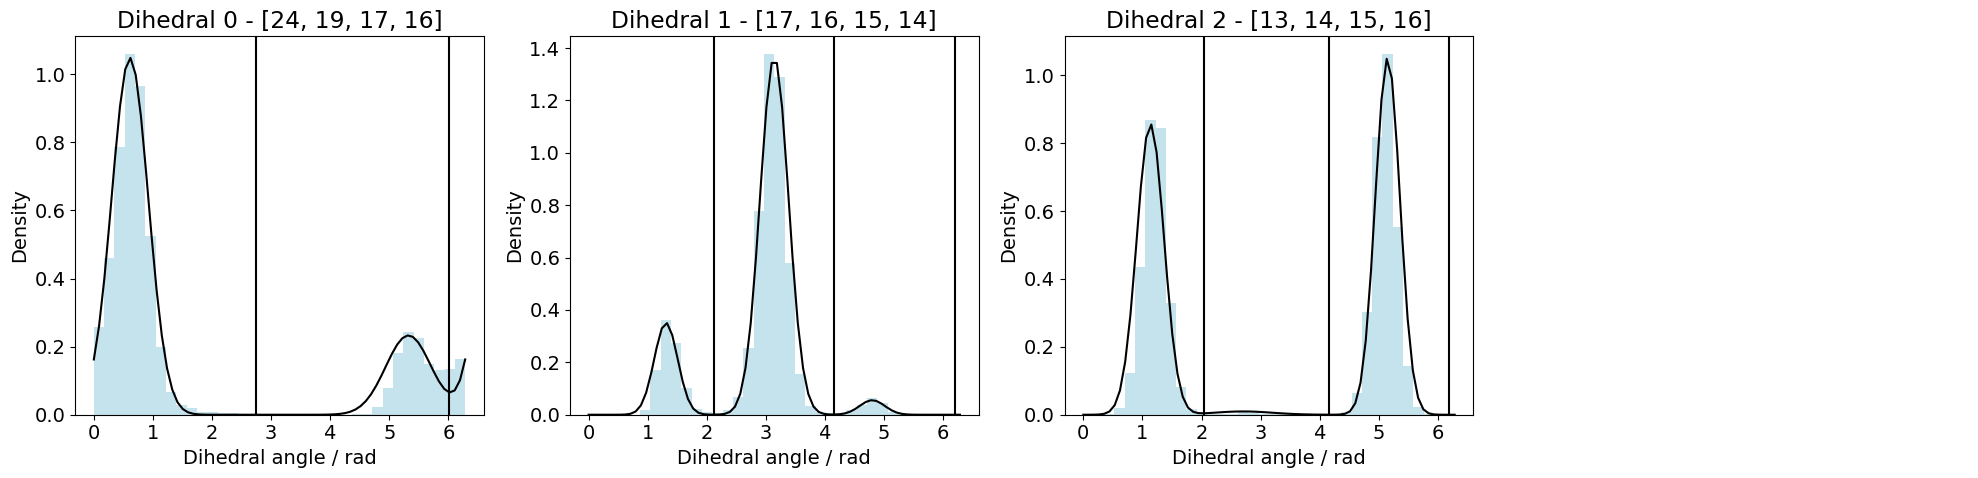

In [46]:
tmp = profiles[tuple(indicesOfInterest[0])]
customProfiles = np.hstack([tmp, profiles[tuple(indicesOfInterest[1])]])
customProfiles = np.hstack([customProfiles, profiles[tuple(indicesOfInterest[2])]])
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles,binsize)
info2 = custom.CustomDihedralInfo(mol, indicesOfInterest, customProfiles, showFits=True)

Inspecting the target dihedral distribution in detail

Text(0, 0.5, 'Density')

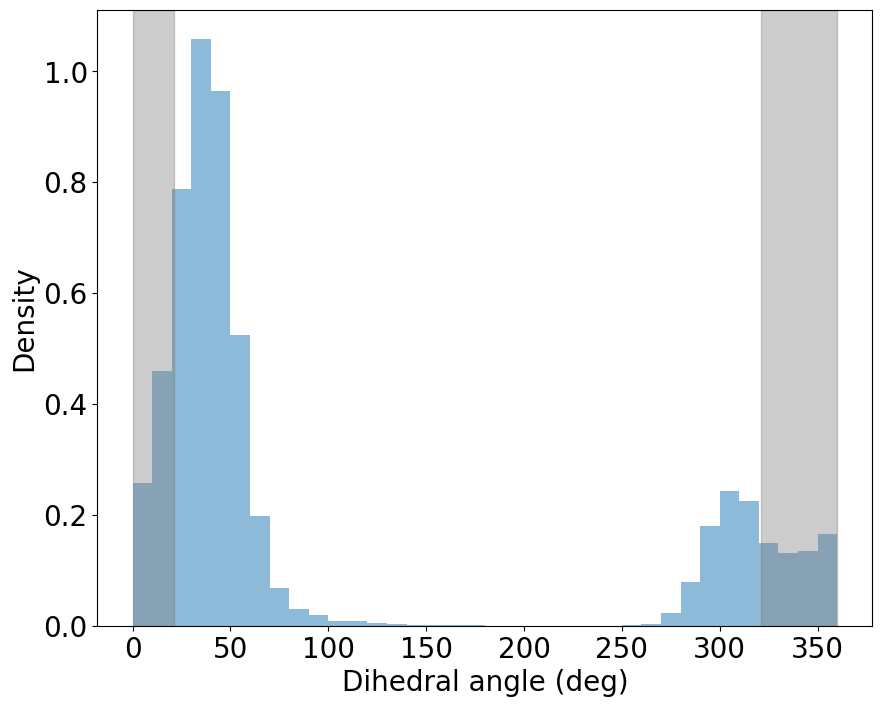

In [47]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(np.rad2deg(xHist), yHists[0], width=np.rad2deg(binsize), alpha=0.5)
ax.axvspan(0, 21, color='grey', alpha=0.4)
ax.axvspan(321, 360, color='grey', alpha=0.4)
ax.set_xlabel("Dihedral angle (deg)")
ax.set_ylabel("Density")

Also shifted so that it is -180 to 180 degrees

Text(0, 0.5, 'Density')

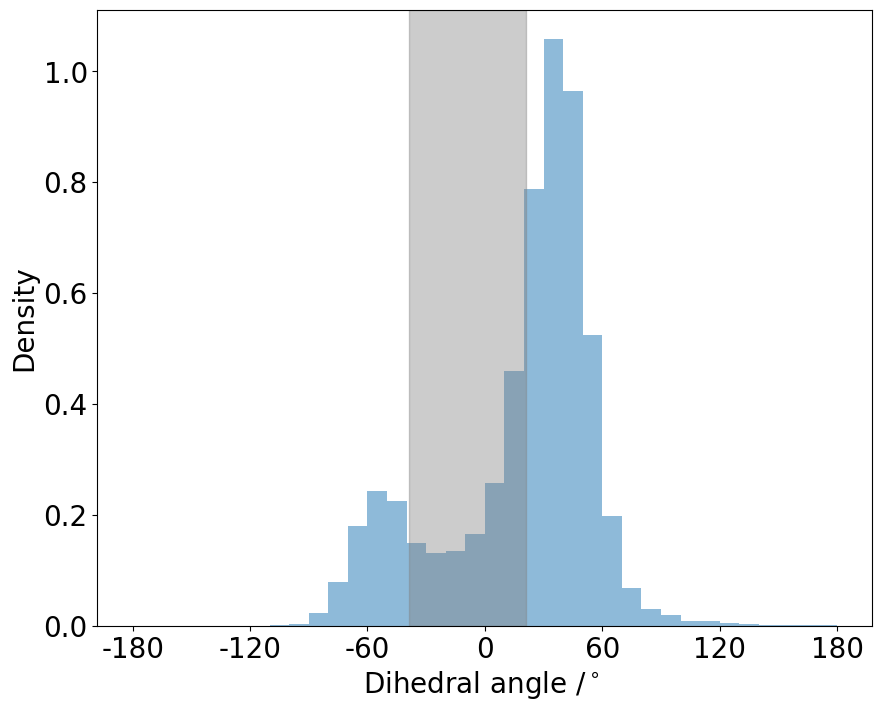

In [48]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(Shift(np.rad2deg(xHist)), yHists[0], width=np.rad2deg(binsize), alpha=0.5)
ax.axvspan(Shift([321])[0], Shift([21])[0], color='grey', alpha=0.4)
labels = np.arange(-180, 181, 60)
ax.set_xticks(labels)
ax.set_xticklabels(labels)
ax.set_xlabel(r"Dihedral angle /$^\circ$ ")
ax.set_ylabel("Density")

Checking the correlation between the target dihedral and [13,14,15,16]

In [49]:
tmp = profiles[tuple(indicesOfInterest[0])]
customProfiles = np.hstack([tmp, profiles[tuple(indicesOfInterest[2])]])
info3 = custom.CustomDihedralInfo(mol, [indicesOfInterest[0],
                                        indicesOfInterest[2]], customProfiles)
tabsPopulationTraj = info3.GetTABS(confTorsions=customProfiles)
unique, counts = np.unique(tabsPopulationTraj, return_counts=True)

In [50]:
#get all indices of the TABS that have 1 as the first value
indices1 = []
indices2 = []
for i in range(len(tabsPopulationTraj)):
    if str(tabsPopulationTraj[i]).startswith("1"):
        indices1.append(i)
    if str(tabsPopulationTraj[i]).startswith("2"):
        indices2.append(i)

Text(0.5, 0, 'Dihedral angle (rad)')

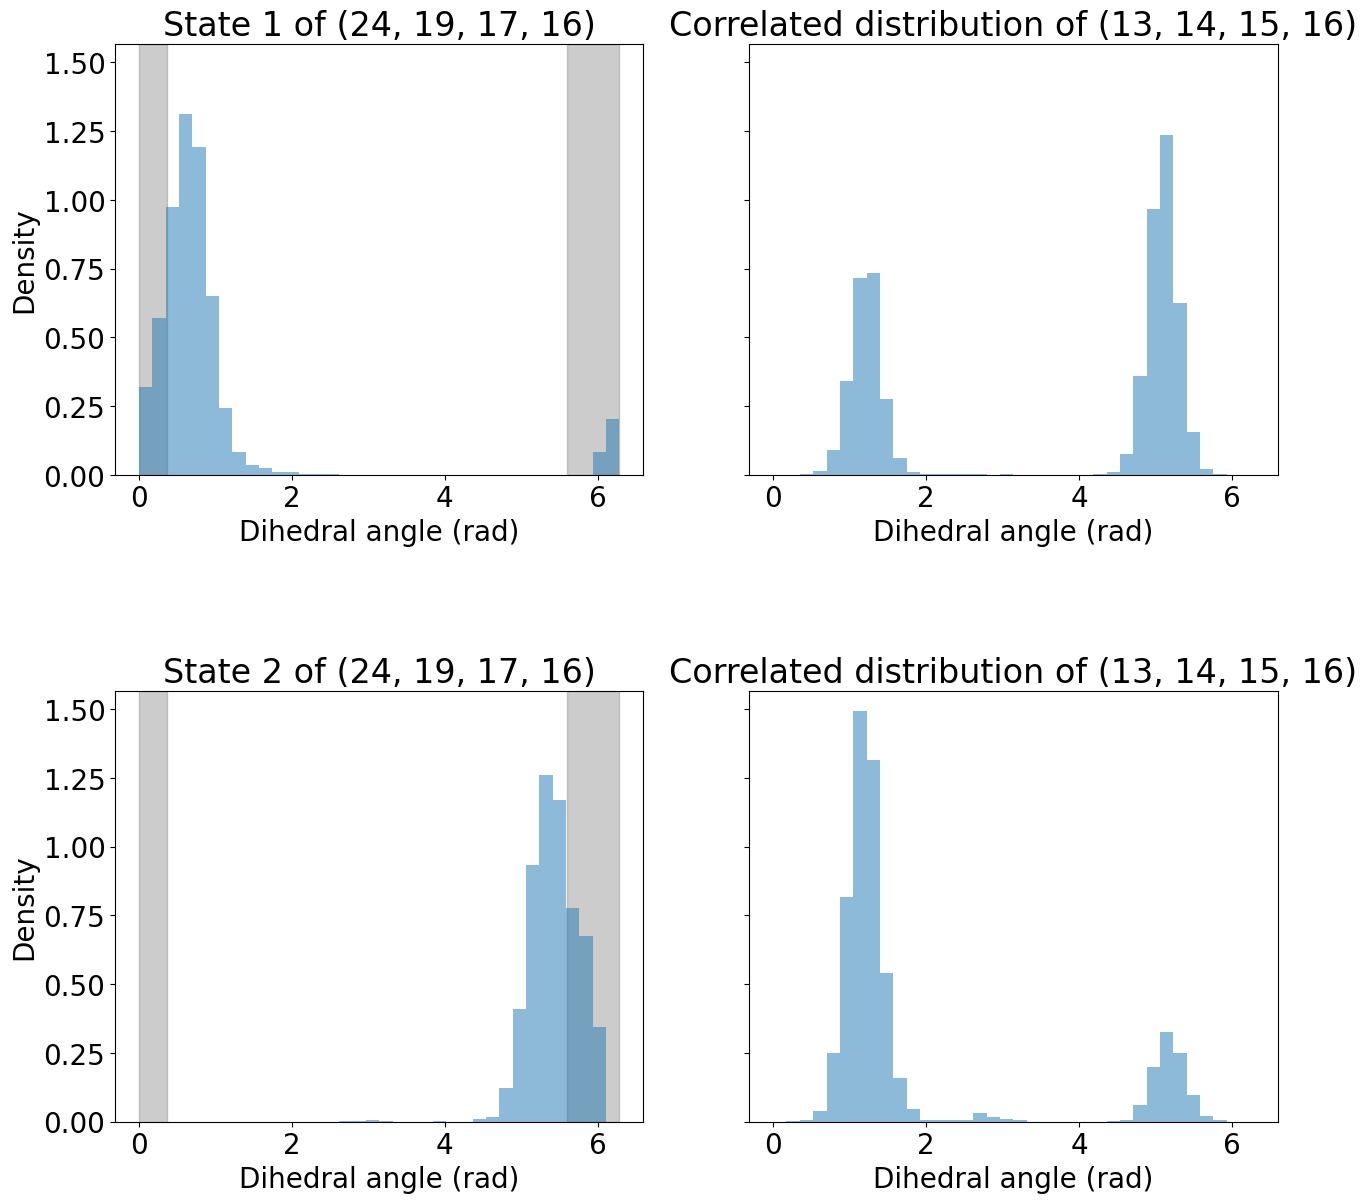

In [51]:
plt.rcParams['font.size'] = 20
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles[indices1,:],binsize)
yHists2, yHistsCount2, xHist2 = custom.ComputeTorsionHistograms(customProfiles[indices2,:],binsize)
fig, ax = plt.subplots(2, 2, figsize=(15, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
ax[0][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[0][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[0][0].set_title("State 1 of (24, 19, 17, 16)")
ax[0][0].bar(xHist, yHists[0], width=binsize, alpha=0.5)
ax[0][0].set_xlabel("Dihedral angle (rad)")
ax[0][0].set_ylabel("Density")
ax[0][1].set_title("Correlated distribution of (13, 14, 15, 16)")
ax[0][1].bar(xHist, yHists[1], width=binsize, alpha=0.5)
ax[0][1].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_title("State 2 of (24, 19, 17, 16)")
ax[1][0].bar(xHist2, yHists2[0], width=binsize, alpha=0.5)
ax[1][0].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_ylabel("Density")
ax[1][1].set_title("Correlated distribution of (13, 14, 15, 16)")
ax[1][1].bar(xHist2, yHists2[1], width=binsize, alpha=0.5)
ax[1][1].set_xlabel("Dihedral angle (rad)")

Also plot this in degrees and from -180 to 180

Text(0.5, 0, 'Dihedral angle / $^\\circ$ ')

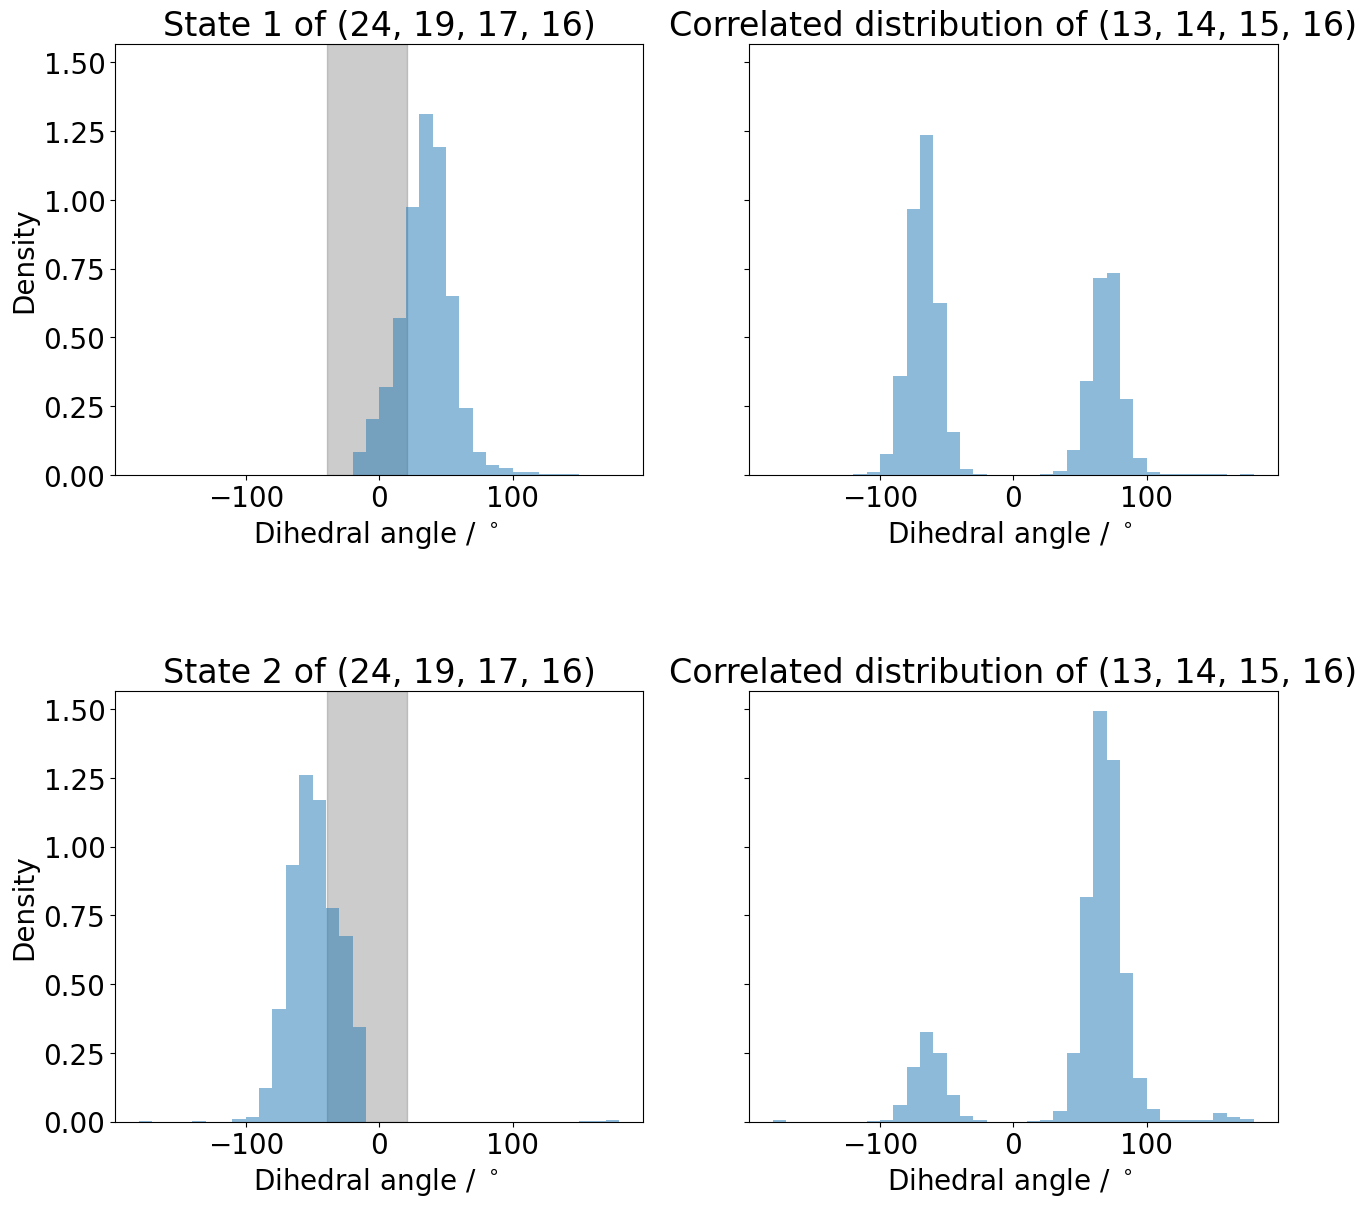

In [52]:
plt.rcParams['font.size'] = 20
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles[indices1,:],binsize)
yHists2, yHistsCount2, xHist2 = custom.ComputeTorsionHistograms(customProfiles[indices2,:],binsize)
fig, ax = plt.subplots(2, 2, figsize=(15, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)

ax[0][0].axvspan(Shift([321])[0], Shift([21])[0], color='grey', alpha=0.4)
ax[1][0].axvspan(Shift([321])[0], Shift([21])[0], color='grey', alpha=0.4)

ax[0][0].set_title("State 1 of (24, 19, 17, 16)")
ax[0][0].bar(Shift(np.rad2deg(xHist)), yHists[0], width=np.rad2deg(binsize), alpha=0.5)
ax[0][0].set_xlabel(r"Dihedral angle / $^\circ$ ")
ax[0][0].set_ylabel("Density")
ax[0][1].set_title("Correlated distribution of (13, 14, 15, 16)")
ax[0][1].bar(Shift(np.rad2deg(xHist)), yHists[1], width=np.rad2deg(binsize), alpha=0.5)
ax[0][1].set_xlabel(r"Dihedral angle / $^\circ$ ")
ax[1][0].set_title("State 2 of (24, 19, 17, 16)")
ax[1][0].bar(Shift(np.rad2deg(xHist2)), yHists2[0], width=np.rad2deg(binsize), alpha=0.5)
ax[1][0].set_xlabel(r"Dihedral angle / $^\circ$ ")
ax[1][0].set_ylabel("Density")
ax[1][1].set_title("Correlated distribution of (13, 14, 15, 16)")
ax[1][1].bar(Shift(np.rad2deg(xHist2)), yHists2[1], width=np.rad2deg(binsize), alpha=0.5)
ax[1][1].set_xlabel(r"Dihedral angle / $^\circ$ ")

Checking the correlation between the target dihedral and [17,16,15,14]

In [54]:
tmp = profiles[tuple(indicesOfInterest[0])]
customProfiles = np.hstack([tmp, profiles[tuple(indicesOfInterest[1])]])
info2 = custom.CustomDihedralInfo(mol, [indicesOfInterest[0],
                                        indicesOfInterest[1]], customProfiles)
tabsPopulationTraj = info2.GetTABS(confTorsions=customProfiles)

In [55]:
# count the number for each unique value
unique, counts = np.unique(tabsPopulationTraj, return_counts=True)

In [56]:
#get all indices of the TABS that have 1 as the first value
indices1 = []
indices2 = []
for i in range(len(tabsPopulationTraj)):
    if str(tabsPopulationTraj[i]).startswith("1"):
        indices1.append(i)
    if str(tabsPopulationTraj[i]).startswith("2"):
        indices2.append(i)

Text(0.5, 0, 'Dihedral angle (rad)')

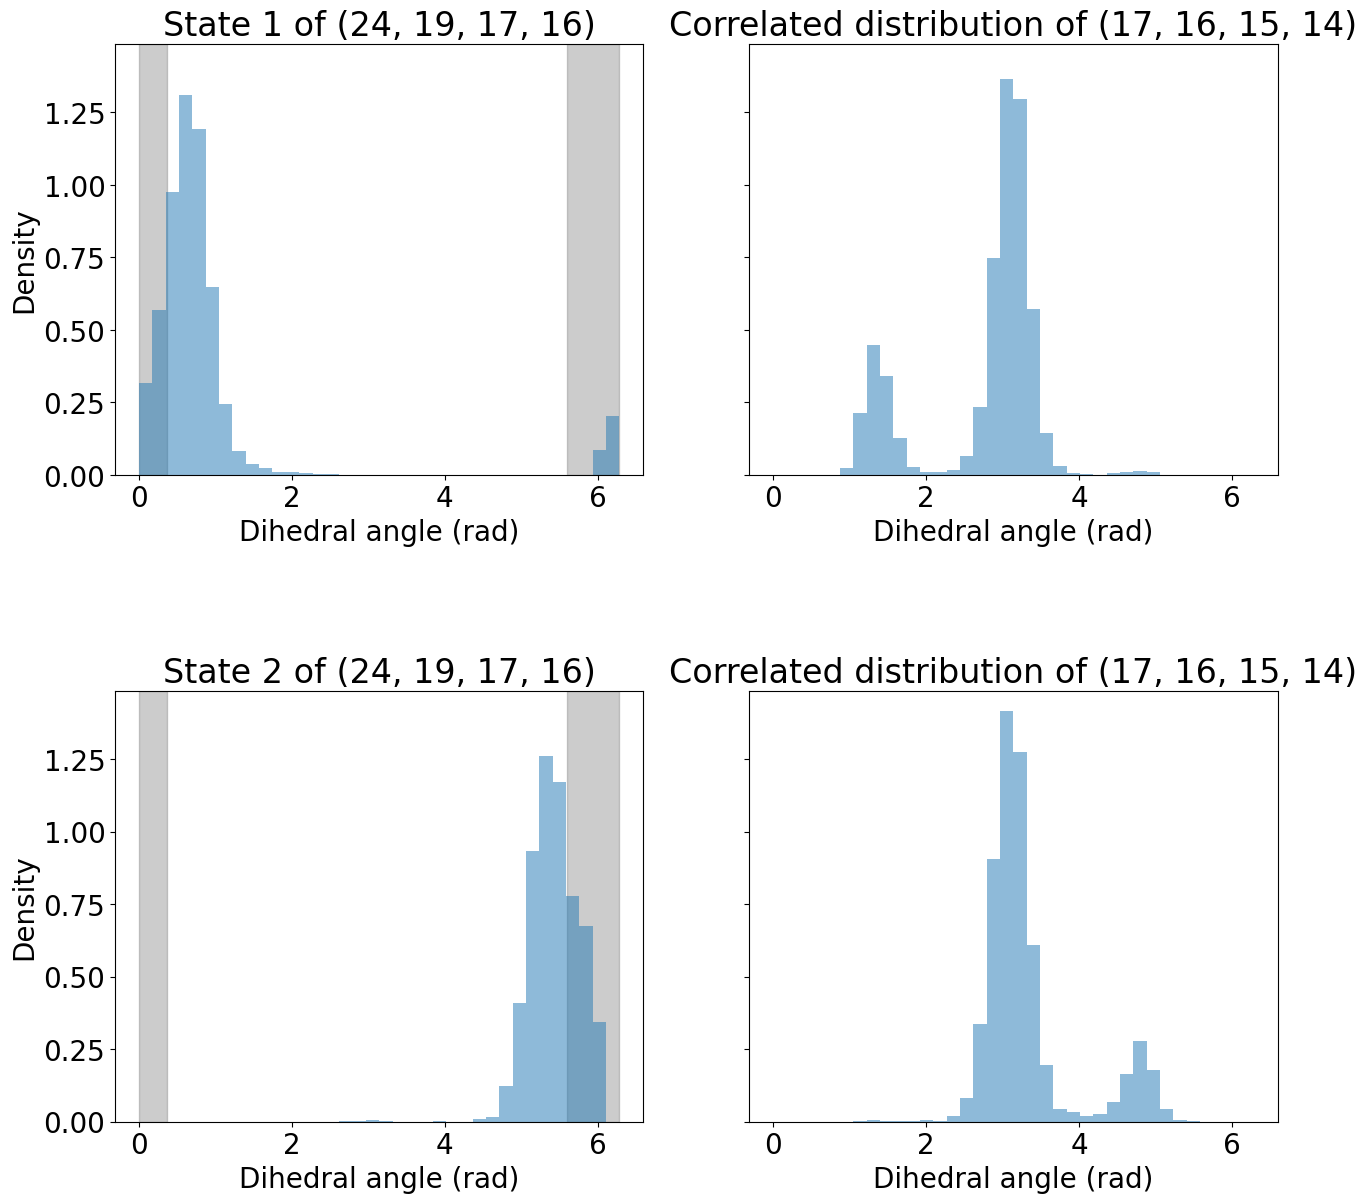

In [57]:
plt.rcParams['font.size'] = 20
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles[indices1,:],binsize)
yHists2, yHistsCount2, xHist2 = custom.ComputeTorsionHistograms(customProfiles[indices2,:],binsize)
fig, ax = plt.subplots(2, 2, figsize=(15, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)
ax[0][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[0][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(0), np.deg2rad(21), color='grey', alpha=0.4)
ax[1][0].axvspan(np.deg2rad(321), np.deg2rad(360), color='grey', alpha=0.4)
ax[0][0].set_title("State 1 of (24, 19, 17, 16)")
ax[0][0].bar(xHist, yHists[0], width=binsize, alpha=0.5)
ax[0][0].set_xlabel("Dihedral angle (rad)")
ax[0][0].set_ylabel("Density")
ax[0][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[0][1].bar(xHist, yHists[1], width=binsize, alpha=0.5)
ax[0][1].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_title("State 2 of (24, 19, 17, 16)")
ax[1][0].bar(xHist2, yHists2[0], width=binsize, alpha=0.5)
ax[1][0].set_xlabel("Dihedral angle (rad)")
ax[1][0].set_ylabel("Density")
ax[1][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[1][1].bar(xHist2, yHists2[1], width=binsize, alpha=0.5)
ax[1][1].set_xlabel("Dihedral angle (rad)")

Also plot this in degrees and from -180 to 180

Text(0.5, 0, 'Dihedral angle / $^\\circ$ ')

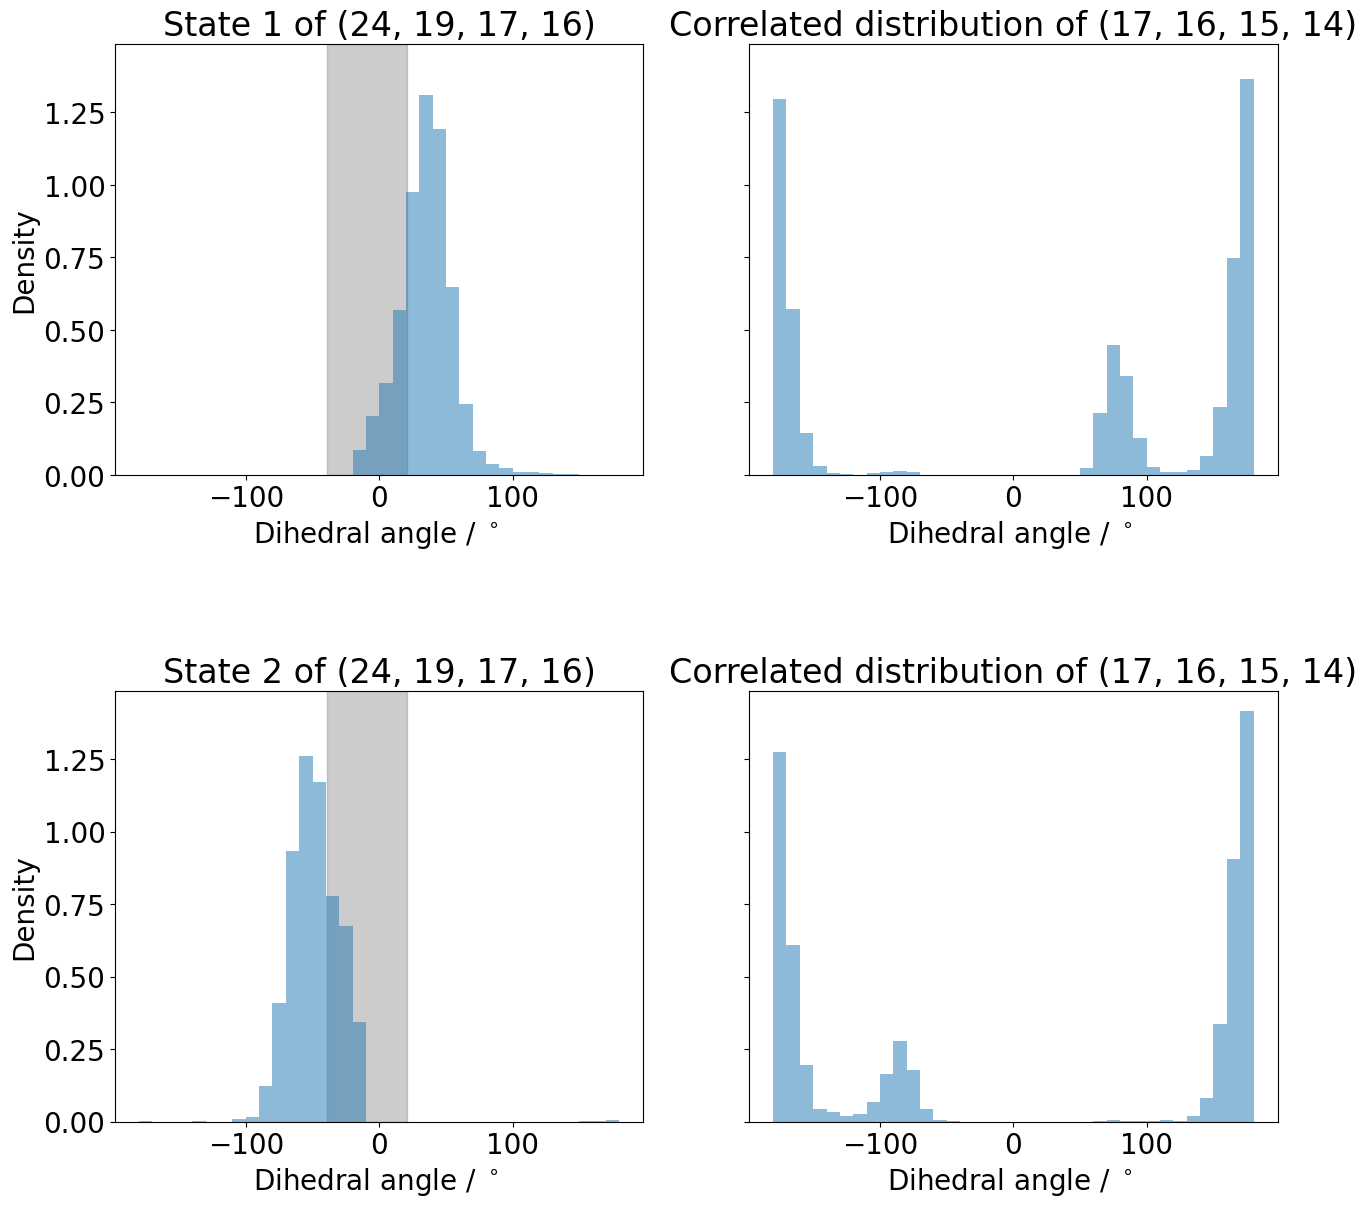

In [60]:
plt.rcParams['font.size'] = 20
yHists, yHistsCount, xHist = custom.ComputeTorsionHistograms(customProfiles[indices1,:],binsize)
yHists2, yHistsCount2, xHist2 = custom.ComputeTorsionHistograms(customProfiles[indices2,:],binsize)
fig, ax = plt.subplots(2, 2, figsize=(15, 14), sharey=True)
plt.subplots_adjust(hspace=0.5)

ax[0][0].axvspan(Shift([321])[0], Shift([21])[0], color='grey', alpha=0.4)
ax[1][0].axvspan(Shift([321])[0], Shift([21])[0], color='grey', alpha=0.4)

ax[0][0].set_title("State 1 of (24, 19, 17, 16)")
ax[0][0].bar(Shift(np.rad2deg(xHist)), yHists[0], width=np.rad2deg(binsize), alpha=0.5)
ax[0][0].set_xlabel(r"Dihedral angle / $^\circ$ ")
ax[0][0].set_ylabel("Density")
ax[0][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[0][1].bar(Shift(np.rad2deg(xHist)), yHists[1], width=np.rad2deg(binsize), alpha=0.5)
ax[0][1].set_xlabel(r"Dihedral angle / $^\circ$ ")
ax[1][0].set_title("State 2 of (24, 19, 17, 16)")
ax[1][0].bar(Shift(np.rad2deg(xHist2)), yHists2[0], width=np.rad2deg(binsize), alpha=0.5)
ax[1][0].set_xlabel(r"Dihedral angle / $^\circ$ ")
ax[1][0].set_ylabel("Density")
ax[1][1].set_title("Correlated distribution of (17, 16, 15, 14)")
ax[1][1].bar(Shift(np.rad2deg(xHist2)), yHists2[1], width=np.rad2deg(binsize), alpha=0.5)
ax[1][1].set_xlabel(r"Dihedral angle / $^\circ$ ")